In [1]:
import torch
from tqdm import tqdm
from model import Vocaburary, TextGCN
import os
import pickle

c:\Users\Wen2Tee5\Desktop\Postgraduate\final\finalEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCH = 300

In [3]:
dataset_names = {
    "20NewsGroup": "20NG",
    "MR":"mr",
    "Ohsumed":"ohsumed_single_23",
    "R52":"R52",
    "R8":"R8"
}
dir_name = dataset_names['20NewsGroup']

SAVE_PATH = f'./result/{dir_name}_hidden_dim.result'

In [4]:
dict_data = torch.load(f'./ProcessedData/{dir_name}/WholeGraphDict.gh')
dict_data.keys()

dict_keys(['voc', 'train_word', 'test_word', 'whole_graph', 'doc_Y', 'word_Y', 'label_Y', 'train_mask', 'D', 'W', 'L'])

In [5]:
voc : Vocaburary = dict_data['voc']
whole_graph = dict_data['whole_graph'].cuda()
word_num = dict_data['W']
label_num = dict_data['L']
doc_num = dict_data['D']
train_mask = dict_data['train_mask'].cuda()
doc_Y : torch.Tensor = dict_data['doc_Y'].cuda()
word_Y : torch.Tensor = dict_data['word_Y'].T.cuda()
label_Y : torch.Tensor = dict_data['label_Y'].cuda()
train_words = list(dict_data['train_word'])
test_words = list(dict_data['test_word'])
train_words.sort()
test_words.sort()

In [6]:
train_num = train_mask.count_nonzero().cpu().item()
test_num = doc_num - train_num

In [7]:
print({
    "#DOC":doc_num,
    "#Word":word_num,
    "#Class":label_num,
    "#Train" : train_num,
    "#Test" : test_num,
    "#NODE" : word_num + doc_num + label_num
})

{'#DOC': 18846, '#Word': 42757, '#Class': 20, '#Train': 11314, '#Test': 7532, '#NODE': 61623}


In [8]:
if not os.path.exists(SAVE_PATH):
    dim_acc = []
    hidden_dims = list(range(50, 301, 10))
    for hidden_dim in hidden_dims:
        log = {"ACC": [], "LOSS": []}
        model = TextGCN(whole_graph.shape[0], hidden_dim, label_num).cuda()
        optim = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = torch.nn.CrossEntropyLoss()
        trainingProcess = tqdm(range(EPOCH), desc=f"Current HiddenDim = {hidden_dim}")
        for epoch in trainingProcess:
            total_loss = 0.
            optim.zero_grad()
            y_hat = model(whole_graph)
            doc_Y_hat = y_hat[:doc_num]
            word_Y_hat = y_hat[doc_num:-label_num]
            label_Y_hat = y_hat[doc_num+word_num :]
            doc_loss = loss_fn(doc_Y_hat[train_mask], doc_Y[train_mask])
            word_loss = loss_fn(word_Y_hat[train_words], word_Y[train_words])
            label_loss = loss_fn(label_Y_hat, label_Y)
            loss = 1.0 * doc_loss + 0.2 * word_loss  + 1. * label_loss
            loss.backward()
            optim.step()
            loss_val = loss.item()
            with torch.no_grad():
                acc_val = ((doc_Y_hat.argmax(1)[~train_mask] == doc_Y.cuda()[~train_mask]).sum() / (~train_mask).sum()).item()
            trainingProcess.set_postfix({"LOSS": loss_val, "Accuracy":acc_val})
            log['ACC'].append(acc_val)
            log["LOSS"].append(loss_val)
        dim_acc.append(max(log['ACC']))
    result = {"hidden_dims" : hidden_dims, "Accuracy" : dim_acc}
    with open(SAVE_PATH, 'wb') as f:
        pickle.dump(result, f)
else:
    with open(SAVE_PATH, 'rb') as f:
        result = pickle.load(f)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

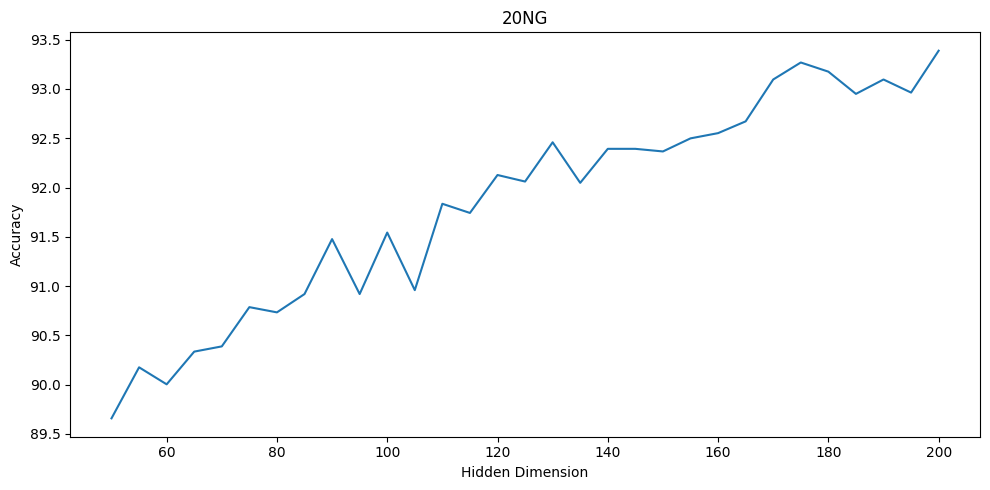

In [13]:
fig : Figure = plt.figure(figsize=(10.,5.))
plt.plot(result['hidden_dims'][:-20], list(map(lambda x : x * 100, result['Accuracy']))[:-20])
# plt.plot(result['Accuracy'], list(map(lambda x : x * 100, result['Accuracy'])))
plt.title(f"{dir_name}")
plt.xlabel("Hidden Dimension")
plt.ylabel('Accuracy')
fig.tight_layout()
plt.show()
fig.savefig('./result/HiddenDimension.svg', transparent=True, format ='svg')